In [ ]:

import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount("/content/drive")



Mounted at /content/drive


In [ ]:
# Function to load and preprocess images
def load_images(directory):
    images = []
    labels = []

    for class_label, class_name in enumerate(['Au', 'Tp']):
        class_directory = os.path.join(directory, class_name)

        for image_path in os.listdir(class_directory):
            image_path_full = os.path.join(class_directory, image_path)

            # Check if the path is a file and if it is an image
            if os.path.isfile(image_path_full) and image_path_full.lower().endswith(('.png', '.jpg', '.jpeg')):
                image = cv2.imread(image_path_full)

                # Check if the image is successfully loaded
                if image is None:
                    print(f"Warning: Unable to load image at {image_path_full}")
                    continue

                image = cv2.resize(image, (128, 128))  # Resize for consistency
                images.append(image)
                labels.append(class_label)  # Label 0 for 'Au' (authentic), 1 for 'Tp' (tampered)

    return np.array(images), np.array(labels)



In [ ]:
# Load and preprocess the CASIA2 dataset
images, labels = load_images('/content/drive/My Drive/CASIA/CASIA2')

# Check the number of loaded images and labels
print("Number of images:", len(images))
print("Number of labels:", len(labels))


Number of images: 9501
Number of labels: 9501


In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    images,
    labels,
    test_size=0.2,
    random_state=42
)

# Data Augmentation
train_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_gen = ImageDataGenerator()

In [ ]:


# Define a more  CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.7),  # for regularization
    layers.Dense(1, activation='sigmoid')
])


In [ ]:
# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [ ]:
# Early Stopping
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    train_gen.flow(X_train, y_train, batch_size=32),
    validation_data=test_gen.flow(X_test, y_test, batch_size=32),
    epochs=5,
    steps_per_epoch=len(X_train) // 32,
    callbacks=[early_stopping]
)

Epoch 1/5
237/237 [==============================] - 417s 2s/step - loss: 2.6540 - accuracy: 0.6780 - val_loss: 0.5848 - val_accuracy: 0.7791
Epoch 2/5
237/237 [==============================] - 438s 2s/step - loss: 0.6180 - accuracy: 0.7544 - val_loss: 0.5562 - val_accuracy: 0.7833
Epoch 3/5
237/237 [==============================] - 428s 2s/step - loss: 0.5709 - accuracy: 0.7767 - val_loss: 0.5276 - val_accuracy: 0.7833
Epoch 4/5
237/237 [==============================] - 437s 2s/step - loss: 0.5611 - accuracy: 0.7762 - val_loss: 0.5254 - val_accuracy: 0.7833
Epoch 5/5
237/237 [==============================] - 416s 2s/step - loss: 0.5560 - accuracy: 0.7803 - val_loss: 0.5209 - val_accuracy: 0.7833


In [ ]:

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')


60/60 [==============================] - 24s 395ms/step - loss: 0.5209 - accuracy: 0.7833
Test Accuracy: 0.7832719683647156


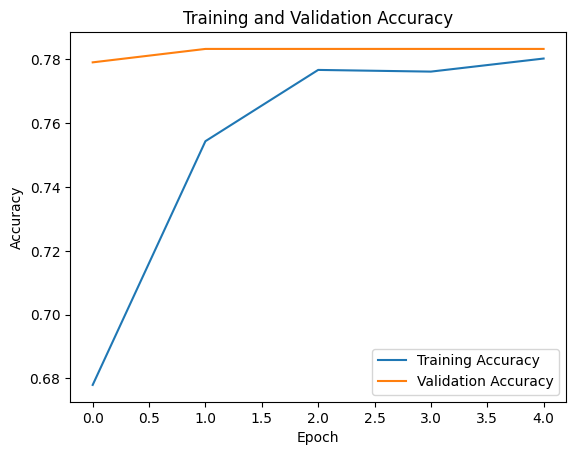

In [ ]:

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


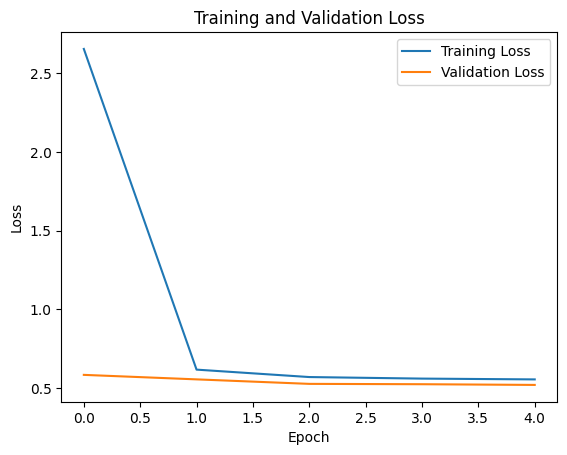

In [ ]:

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()